In [358]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import re

In [ ]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)
movie_df = pd.read_csv(movielens_dir / "movies.csv")

In [581]:
genres_dict = dict()
for movie in movie_ids:
    for genre in movie_df[movie_df.movieId == movie].iloc[0]['genres'].split('|'):
        if genre in genres_dict.keys():
            genres_dict[genre] = genres_dict[genre] + 1
        else: genres_dict[genre] = 1

In [582]:
genres_dict = {k: v for k, v in sorted(genres_dict.items(), key=lambda item: item[1],reverse=True)}
genres_dict

{'Drama': 4349,
 'Comedy': 3753,
 'Thriller': 1889,
 'Action': 1828,
 'Romance': 1591,
 'Adventure': 1262,
 'Crime': 1196,
 'Sci-Fi': 980,
 'Horror': 977,
 'Fantasy': 778,
 'Children': 664,
 'Animation': 610,
 'Mystery': 573,
 'Documentary': 438,
 'War': 381,
 'Musical': 333,
 'Western': 167,
 'IMAX': 158,
 'Film-Noir': 85,
 '(no genres listed)': 34}

In [401]:
df.head()

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727


In [546]:
len(df)/num_users

165.30491803278687

In [244]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [246]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [247]:
embedding_dim = 32
hidden_units = [64, 32]

user_input = tf.keras.Input(shape=(1,), dtype=tf.int32, name='user_input')
movie_input = tf.keras.Input(shape=(1,), dtype=tf.int32, name='movie_input')

user_embedding = tf.keras.layers.Embedding(input_dim=num_users, output_dim=embedding_dim,name='user_embedding')(user_input)
movie_embedding = tf.keras.layers.Embedding(input_dim=num_movies, output_dim=embedding_dim)(movie_input)

user_embedding = tf.keras.layers.Flatten()(user_embedding)
movie_embedding = tf.keras.layers.Flatten()(movie_embedding)

concatenated = tf.keras.layers.Concatenate()([user_embedding, movie_embedding])

for units in hidden_units:
    concatenated = tf.keras.layers.Dense(units, activation='relu')(concatenated)

output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated)

model = tf.keras.Model(inputs=[user_input, movie_input], outputs=output)

model.compile(optimizer="Adam",loss="mse")

In [248]:
history = model.fit(
    [x_train[:, 0], x_train[:, 1]],
    y_train,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
    batch_size=64,
    epochs=5
)

Epoch 1/5
1418/1418 [==============================] - 17s 10ms/step - loss: 0.0405 - val_loss: 0.0380
Epoch 2/5
1418/1418 [==============================] - 15s 11ms/step - loss: 0.0336 - val_loss: 0.0372
Epoch 3/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.0305 - val_loss: 0.0377
Epoch 4/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.0273 - val_loss: 0.0384
Epoch 5/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.0242 - val_loss: 0.0395


In [249]:
user_embeddings = model.get_layer('user_embedding').get_weights()[0]

similarity_matrix = 1 - cosine_distances(user_embeddings)

In [421]:
display(pd.DataFrame(similarity_matrix))

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,1.000000,0.264383,-0.613206,-0.229161,0.261551,0.378222,-0.325793,0.157095,0.349679,-0.372233,...,0.706331,-0.121211,0.062191,0.249877,-0.210611,0.065019,0.030651,-0.365440,-0.375037,0.488165
1,0.264383,1.000000,0.159473,-0.192006,-0.053792,0.259285,-0.286224,0.046180,-0.224200,0.423087,...,0.350676,0.240784,0.031797,0.273338,0.342674,0.010282,0.041147,0.147127,0.459160,-0.231723
2,-0.613206,0.159473,1.000000,-0.181789,-0.112798,-0.060909,0.121377,-0.285021,-0.282613,0.644602,...,-0.627157,0.286374,0.087407,-0.041731,0.274048,-0.205709,-0.275714,0.509778,0.451671,-0.500966
3,-0.229161,-0.192006,-0.181789,1.000000,-0.019498,-0.491685,0.268707,-0.182132,0.002905,-0.413459,...,-0.166526,0.003666,0.461847,-0.128613,0.151311,0.291584,0.173413,-0.081673,0.138499,-0.212888
4,0.261551,-0.053792,-0.112798,-0.019498,1.000000,-0.215664,-0.040404,0.175228,0.378193,-0.296374,...,-0.044811,-0.037972,0.519394,0.103446,-0.385775,0.001546,-0.299860,-0.162234,-0.195156,0.154535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.065019,0.010282,-0.205709,0.291584,0.001546,-0.140977,-0.153085,0.165216,-0.203293,-0.327315,...,0.269424,-0.358094,0.240152,0.104547,-0.273745,1.000000,-0.096097,0.053931,0.219093,-0.203310
606,0.030651,0.041147,-0.275714,0.173413,-0.299860,0.044776,0.108556,0.420489,-0.434003,0.028072,...,0.222328,-0.304451,-0.206082,0.112550,0.205652,-0.096097,1.000000,-0.153497,0.028389,0.017297
607,-0.365440,0.147127,0.509778,-0.081673,-0.162234,-0.238113,0.373744,-0.264760,-0.228175,0.169304,...,-0.227594,-0.211843,-0.166326,0.113773,-0.058652,0.053931,-0.153497,1.000000,0.239314,-0.310320
608,-0.375037,0.459160,0.451671,0.138499,-0.195156,-0.056081,0.093681,0.099012,-0.504568,0.459528,...,-0.103514,0.217570,0.061742,0.241025,0.478412,0.219093,0.028389,0.239314,1.000000,-0.383362


In [302]:
target_user_id = 1

In [250]:
k_means = KMeans(n_clusters = 5,n_init = 'auto').fit(user_embeddings)

In [561]:
def TF_IDF(movieId):
    tf = len(df[(df.movieId == movieId)]) / len(df)
    k = 0
    rating = 0
    for user_id in user_ids:
        curr_favourite_movies = df[df.userId == user_id].sort_values(by="rating", ascending=False).head(30).movieId.values
        if movieId in curr_favourite_movies:
            k+=1
            rating += df[(df.userId == user_id) & (df.movieId == movieId)].iloc[0]['rating'].astype(float)
    if k != 0:
        idf = math.log(num_users / k)
        return tf*idf*rating
    else: return 0

In [553]:
def get_recommended_movies_for_cluster(label,target_cluster):
    movies_dict = dict()
    num_users_cluster = len(np.where(label == target_cluster)[0])
    for user in user2user_encoded.values():
        if label[user] == taret_cluster:
            recommended_movies = get_recommended_movies(userencoded2user[user],30)
            for movie in recommended_movies:
                if(movie in movies_dict.keys()):
                    movies_dict[movie] = movies_dict[movie] + df[df.movieId == movie]['rating'].iloc[0].astype(float)
                else:
                    movies_dict[movie] = df[df.movieId==movie]['rating'].iloc[0].astype(float)
    movies_dict = {k: v for k, v in sorted(movies_dict.items(), key=lambda item: item[1],reverse=True)}
    for key in movies_dict.keys():
        movies_dict[key] = (movies_dict[key]/num_users_cluster)
    return movies_dict

In [554]:
movies_dict = get_recommended_movies_for_cluster(k_means.labels_,k_means.labels_[0])

281/281 [==============================] - 1s 2ms/step


In [556]:
movies_dict

{177593: 2.3949579831932772,
 5747: 1.6638655462184875,
 3030: 1.6638655462184875,
 3347: 1.546218487394958,
 1178: 1.5126050420168067,
 475: 1.4285714285714286,
 158966: 1.096638655462185,
 26810: 1.0588235294117647,
 27156: 0.9747899159663865,
 106642: 0.9663865546218487,
 1251: 0.9663865546218487,
 6460: 0.8319327731092437,
 260: 0.7983193277310925,
 170705: 0.7983193277310925,
 1203: 0.7941176470588235,
 4973: 0.7563025210084033,
 2732: 0.7394957983193278,
 3224: 0.7142857142857143,
 69481: 0.680672268907563,
 31364: 0.6722689075630253,
 2239: 0.6722689075630253,
 3741: 0.6722689075630253,
 3435: 0.6302521008403361,
 918: 0.6302521008403361,
 7121: 0.6302521008403361,
 7361: 0.5882352941176471,
 318: 0.5882352941176471,
 3201: 0.5714285714285714,
 171763: 0.5714285714285714,
 116897: 0.5672268907563025,
 3468: 0.5462184873949579,
 6818: 0.5462184873949579,
 7842: 0.5294117647058824,
 1221: 0.5042016806722689,
 4537: 0.49159663865546216,
 4298: 0.49159663865546216,
 6874: 0.49159663

In [562]:
movie_dict_with_TF_IDF = dict()
for key in movies_dict.keys():
    tf_idf = TF_IDF(key)
    if(tf_idf != 0):
        movie_dict_with_TF_IDF[key] = movies_dict[key]*tf_idf

In [563]:
movie_dict_with_TF_IDF = {k: v for k, v in sorted(movie_dict_with_TF_IDF.items(), key=lambda item: item[1],reverse=True)}
movie_dict_with_TF_IDF

{318: 1.9273685646630907,
 260: 1.7379766326430401,
 296: 1.0181757481195621,
 858: 0.6338390116152358,
 4973: 0.5159734370511518,
 2959: 0.44898635834114464,
 7361: 0.4459448219495451,
 1221: 0.3736699640934664,
 6874: 0.30669751338404855,
 1196: 0.2710009965654466,
 1208: 0.23525064854577155,
 4993: 0.23318399298325204,
 608: 0.2003687644643299,
 1198: 0.19348629979985502,
 527: 0.16727996235586043,
 1136: 0.16431123394789218,
 58559: 0.15408290061076568,
 1203: 0.15156034868699345,
 7153: 0.1319713246827003,
 1193: 0.12900291535767952,
 32: 0.11149398251393215,
 1089: 0.11107771189660974,
 3147: 0.0807546056251115,
 904: 0.07912570901387388,
 750: 0.07393668752754554,
 7438: 0.07392128353011337,
 475: 0.07061585941968203,
 1732: 0.0640432566704696,
 8368: 0.05624675373168568,
 1704: 0.05225113287467715,
 1527: 0.04246038250847475,
 1080: 0.040314881420070926,
 55820: 0.039585243359597067,
 2858: 0.03752158750010186,
 3793: 0.03633233817259822,
 8874: 0.0354609797822615,
 1172: 0.035

In [564]:
print("Showing recommendations for user: {}".format(target_user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = get_favourite_movies(target_user_id,10)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 1
Movies with high ratings from user
--------------------------------
Tommy Boy (1995) : Comedy
Tombstone (1993) : Action|Drama|Western
Three Caballeros, The (1945) : Animation|Children|Musical
Reservoir Dogs (1992) : Crime|Mystery|Thriller
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Star Wars: Episode VI - Return of the Jedi (1983) : Action|Adventure|Sci-Fi
Full Metal Jacket (1987) : Drama|War
Henry V (1989) : Action|Drama|Romance|War
Newton Boys, The (1998) : Crime|Drama
Mad Max (1979) : Action|Adventure|Sci-Fi


In [565]:
movies_watched_by_user = df[df.userId == target_user_id]
recommended_movies = movie_df[(movie_df["movieId"].isin(movie_dict_with_TF_IDF.keys())) & 
                              (~movie_df["movieId"].isin(movies_watched_by_user['movieId']))]
recommended_movies_without_tf_idf = movie_df[(movie_df["movieId"].isin(movies_dict.keys())) & 
                              (~movie_df["movieId"].isin(movies_watched_by_user['movieId']))]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)
print(len(recommended_movies))

Persuasion (1995) : Drama|Romance
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) : Mystery|Sci-Fi|Thriller
Cry, the Beloved Country (1995) : Drama
Heidi Fleiss: Hollywood Madam (1995) : Documentary
Rumble in the Bronx (Hont faan kui) (1995) : Action|Adventure|Comedy|Crime
Hoop Dreams (1994) : Documentary
Shawshank Redemption, The (1994) : Crime|Drama
In the Name of the Father (1993) : Drama
Blade Runner (1982) : Action|Sci-Fi|Thriller
World of Apu, The (Apur Sansar) (1959) : Drama
Ghost in the Shell (Kôkaku kidôtai) (1995) : Animation|Sci-Fi
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Godfather, The (1972) : Crime|Drama
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Vertigo (1958) : Drama|Mystery|Romance|Thriller
Rear Window (1954) : Mystery|Thriller
It Happened One Night (1934) : Comedy|Romance
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
Casablanca (1942) : Drama|Romance
Maltese Falcon, The (1941) : Film-Noir|Mys

In [566]:
genres_4 = dict()
genres_5 = dict()
movies_watched_by_user = df[df.userId == target_user_id]
for movie in movies_watched_by_user.itertuples():
    if(df[(df.userId == target_user_id) & (df.movieId == movie.movieId)].iloc[0]['rating'].astype(int) == 5):
        for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_5.keys()):
                genres_5[genre] = genres_5[genre] + 1
            else: genres_5[genre] = 1
    if(df[(df.userId == target_user_id) & (df.movieId == movie.movieId)].iloc[0]['rating'].astype(int) == 4):
        for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_4.keys()):
                genres_4[genre] = genres_4[genre] + 1
            else: genres_4[genre] = 1

In [567]:
genres_recommended = dict()
for movie in recommended_movies.itertuples():
    for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_recommended.keys()):
                genres_recommended[genre] = genres_recommended[genre] + 1
            else: genres_recommended[genre] = 1

In [568]:
genres_recommended_without_tf_idf = dict()
for movie in recommended_movies_without_tf_idf.itertuples():
    for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_recommended_without_tf_idf.keys()):
                genres_recommended_without_tf_idf[genre] = genres_recommended_without_tf_idf[genre] + 1
            else: genres_recommended_without_tf_idf[genre] = 1

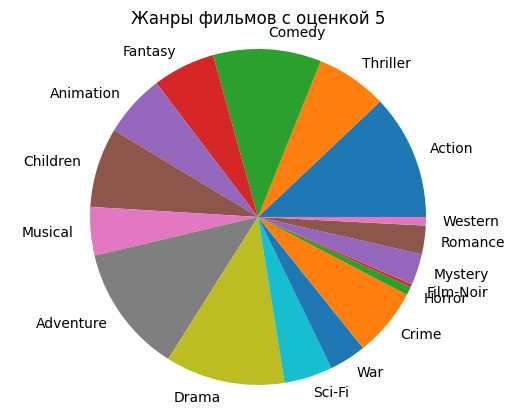

In [569]:
labels = []
sizes = []
for x, y in genres_5.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры фильмов с оценкой 5')
plt.pie(sizes, labels=labels)
plt.axis('equal')

plt.show()

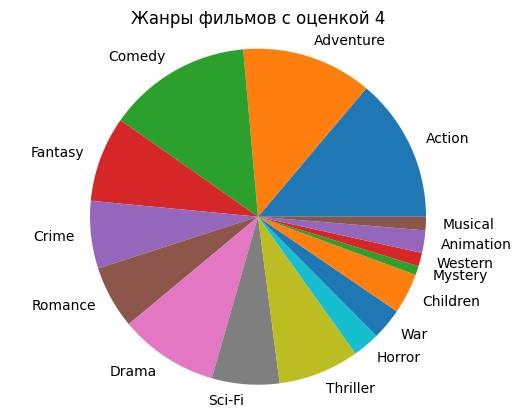

In [570]:
labels = []
sizes = []
for x, y in genres_4.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры фильмов с оценкой 4')
plt.pie(sizes, labels=labels)
plt.axis('equal')
plt.show()

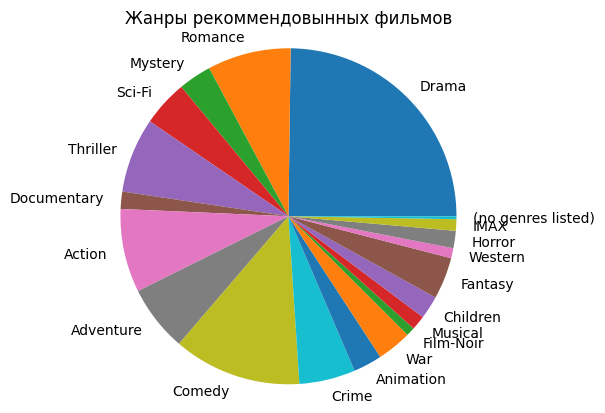

In [571]:
labels = []
sizes = []
for x, y in genres_recommended.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры рекоммендовынных фильмов')
plt.pie(sizes, labels=labels)
plt.axis('equal')

plt.show()

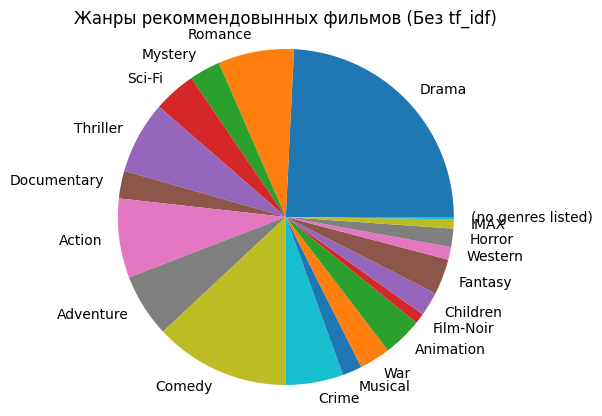

In [572]:
labels = []
sizes = []
for x, y in genres_recommended_without_tf_idf.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры рекоммендовынных фильмов (Без tf_idf)')
plt.pie(sizes, labels=labels)
plt.axis('equal')

plt.show()

In [583]:
def top_n_similar_users(user_id,n):
    return np.argsort(np.delete(similarity_matrix[user_id - 1],user_id - 1))[-n:] + 1

In [584]:
def nth_similar_user(user_id,n):
     return np.argsort(np.delete(similarity_matrix[user_id - 1],user_id - 1))[-(n + 1)] + 1

In [585]:
rmse = 0
n = 10
similar_users = top_n_similar_users(target_user_id,n)
movies_watched_by_user = df[df.userId == target_user_id]
df_user = movies_watched_by_user[['movieId', 'rating']]

for similar_user_id in similar_users:
    movies_watched_by_similar_user = df[df.userId == similar_user_id]
    df_similar_user = movies_watched_by_similar_user[['movieId', 'rating']]  
    corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]['movieId']            
    for movie_id in corresponding_movie_ids:
        rmse += math.pow(df_user[df_user.movieId == movie_id].iloc[0]['rating'] - 
                         df_similar_user[df_similar_user.movieId == movie_id].iloc[0]['rating'],2)
    rmse = math.sqrt(rmse*1/n)
    print(str(rmse) + str(corresponding_movie_ids.shape))

0.6519202405202649(2,)
1.419574592634014(25,)
0.8899199173315548(8,)
0.9690159914744211(4,)
3.3274467086863226(40,)
1.4689263667279693(5,)
1.8565808995766377(35,)
1.08887928162752(12,)
2.7493431812276095(61,)
1.3322666092501008(13,)


In [586]:
tmp_user = []
tmp_similar_user = []

str_target = 'user ' + str(target_user_id)
str_similar = 'user ' + str(similar_users[0])

similar_user_id = similar_users[0]
movies_watched_by_similar_user = df[df.userId == similar_user_id]
df_similar_user = movies_watched_by_similar_user[['movieId', 'rating']]  
corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]['movieId']

comparison_df = pd.DataFrame(index=corresponding_movie_ids,columns=[str_target,str_similar])

for i in corresponding_movie_ids:
    tmp_user.append(float(df[(df['movieId'] ==  i) & (df['userId'] == target_user_id)]['rating'].iloc[0]))
    tmp_similar_user.append(float(df[(df['movieId'] ==  i) & (df['userId'] == similar_user_id)]['rating'].iloc[0]))
    
comparison_df[str_target] = tmp_user
comparison_df[str_similar] = tmp_similar_user
comparison_df

,user 1,user 440
movieId,,
1214,4.0,4.5
3386,5.0,3.0


In [587]:
def get_favourite_movies(target_user_id, n):
    movies_watched_by_user = df[df.userId == target_user_id]
    top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(n)
    .movieId.values
    )
    return top_movies_user

def get_recommended_movies(target_user_id,n):
    movies_watched_by_user = df[df.userId == target_user_id]
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(target_user_id)
    user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    ratings = model.predict([user_movie_array[:, 0],user_movie_array[:, 1]]).flatten()
    top_ratings_indices = ratings.argsort()[-n:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]
    return recommended_movie_ids